In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys, importlib
sys.path.append('/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_shared_packages')
import process_cl2_logfile as process_cl2#This underline us unavoidable
import numpy as np
from IPython.display import display

In [2]:
# For this notebook, we're just going to use a fixed calibration function to estimate Cl2 based on mV from a single initial calibration.
# This differs from the approach used in later data processing notebooks, which account for variations in the Cl2 sensor span due to pressure, etc.
@np.vectorize
def calibrate_cl2(mV):
    return 30*mV/(80.5-43)


<h1> Plotting Conversions, Products, and Efficiencies for the 9-16 Humidity Sweep </h1>

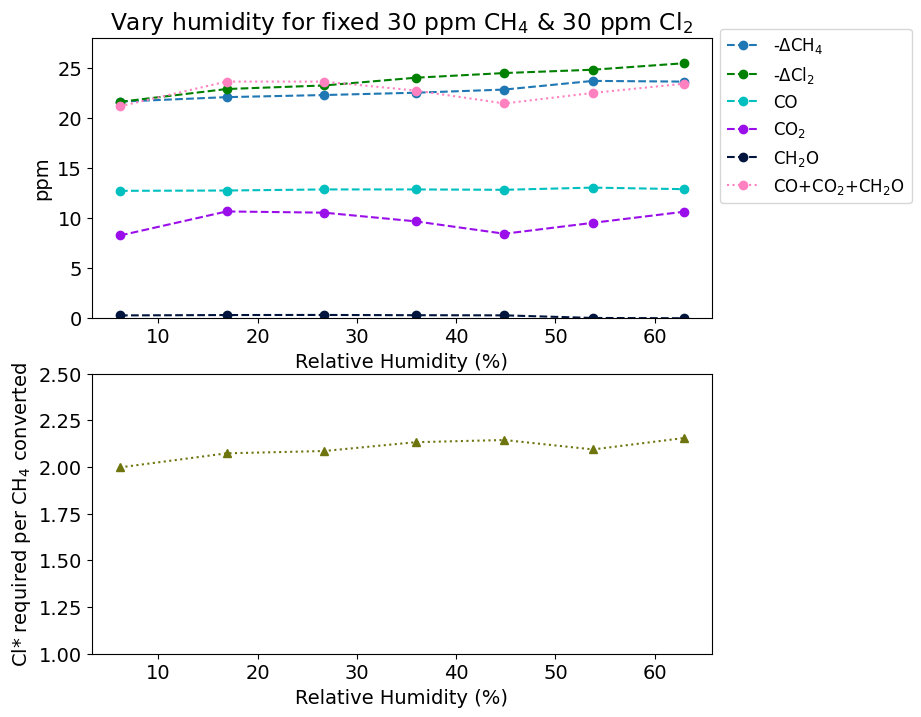

In [3]:
# Let's attempt to plot Cl2 and CH4 conversion vs. humidity
all_bypass_data = pd.read_csv("/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/bypasses_09-24_cl2_sweeps_no_cofeed.csv")
all_conversion_data = pd.read_csv("/Users/work/Desktop/Research/Experimental Data/Fall-2024-Cl2/_exported_data/conversions_09-24_cl2_sweeps_no_cofeed.csv")

# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=='09-16-24 Humidity Sweep (10-60%)']
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=='09-16-24 Humidity Sweep (10-60%)']

cl2_conversions = calibrate_cl2(conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'])
ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
humidities = [float(means[means.closest_start_time==t]['Humidity Probe: Rel. Humidity (%)']) for t in start_times] #Lookup the correct entry in the groupby
humidities = [v*(1.0/(1-6.0/200.0)) for v in humidities] # Scale appropriately to adjust for added chlorine flow
co2 = [float(means[means.closest_start_time==t]['FTIR: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(humidities,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(humidities,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(humidities,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(humidities,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(humidities,ch2o,label='CH$_2$O',color='xkcd:navy',marker='o',linestyle='--')
ax1.plot(humidities,[a+b+c for a,b,c in zip(co,co2,ch2o)],label='CO+CO$_2$+CH$_2$O',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Relative Humidity (%)")
ax1.set_ylim(0,28)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(humidities,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Relative Humidity (%)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1,2.5)

ax1.set_title("Vary humidity for fixed 30 ppm CH$_4$ & 30 ppm Cl$_2$")
plt.show()

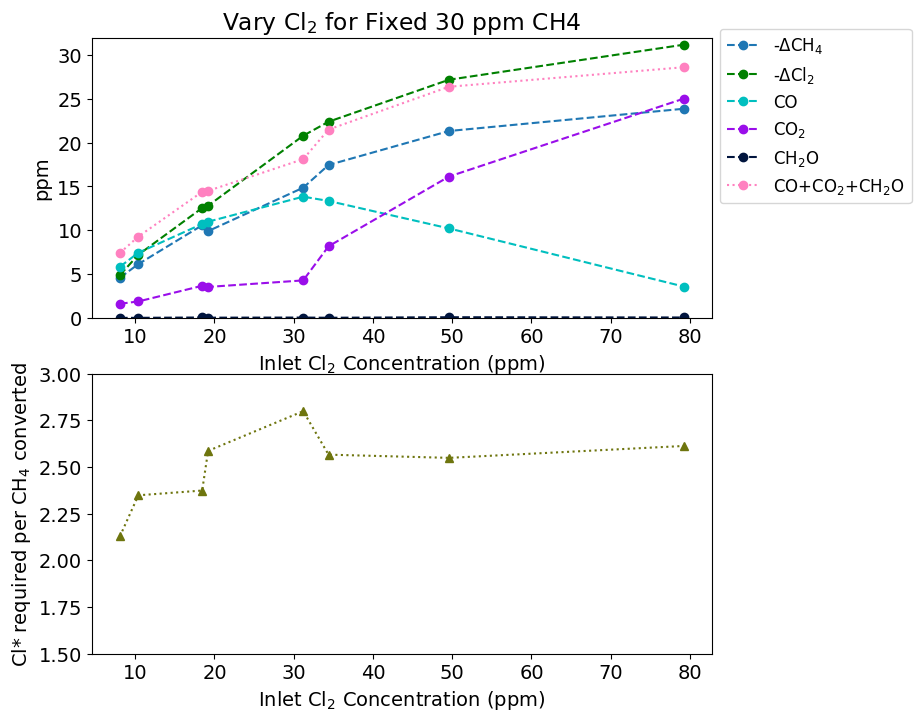

In [4]:
show_low_data = True
# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].str.contains("09-.*at Fixed CH4",regex=True)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].str.contains("09-.*at Fixed CH4",regex=True)]
#bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=="09-17-24 Vary Cl2 (30-90 ppm) at Fixed CH4"]
#conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=="09-17-24 Vary Cl2 (30-90 ppm) at Fixed CH4"]
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)

ch4_conversions = calibrate_cl2(conversion_data['Selected: CH4 (ppm) conversion'])
cl2_conversions = calibrate_cl2(conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'])
inlet_cl2 = calibrate_cl2(conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline'])
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
co2 = [float(means[means.closest_start_time==t]['FTIR: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(inlet_cl2,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(inlet_cl2,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
if True:
    ax1.plot(inlet_cl2,co,label='CO',color='c',marker='o',linestyle='--')
    ax1.plot(inlet_cl2,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
    ax1.plot(inlet_cl2,ch2o,label='CH$_2$O',color='xkcd:navy',marker='o',linestyle='--')
    ax1.plot(inlet_cl2,[a+b+c for a,b,c in zip(co,co2,ch2o)],label='CO+CO$_2$+CH$_2$O',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax1.set_ylim(0,32)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(inlet_cl2,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1.5,3)

ax1.set_title("Vary Cl$_2$ for Fixed 30 ppm CH4")
plt.show()

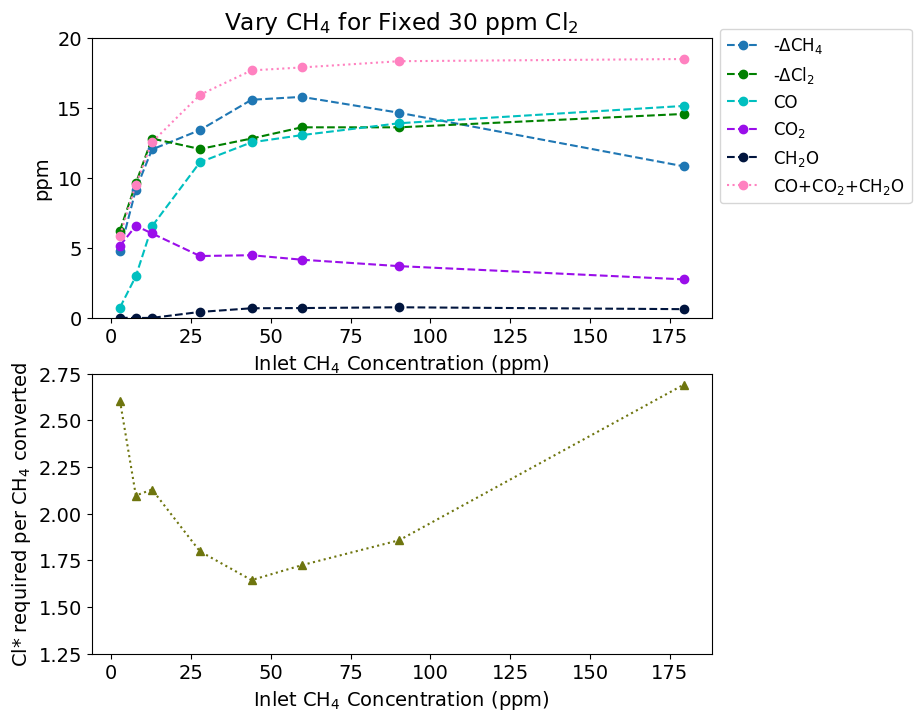

In [5]:
# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"]=="09-17-24 Vary CH4 (10-180 ppm) at Fixed Cl2"]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"]=="09-17-24 Vary CH4 (10-180 ppm) at Fixed Cl2"]

ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
cl2_conversions = calibrate_cl2(conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'])
inlet_ch4 = conversion_data['Selected: CH4 (ppm) baseline']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
co2 = [float(means[means.closest_start_time==t]['FTIR: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(inlet_ch4,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(inlet_ch4,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(inlet_ch4,ch2o,label='CH$_2$O',color='xkcd:navy',marker='o',linestyle='--')
ax1.plot(inlet_ch4,[a+b+c for a,b,c in zip(co,co2,ch2o)],label='CO+CO$_2$+CH$_2$O',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet CH$_4$ Concentration (ppm)")
ax1.set_ylim(0,20)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(inlet_ch4,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Inlet CH$_4$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1.25,2.75)

ax1.set_title("Vary CH$_4$ for Fixed 30 ppm Cl$_2$")
plt.show()

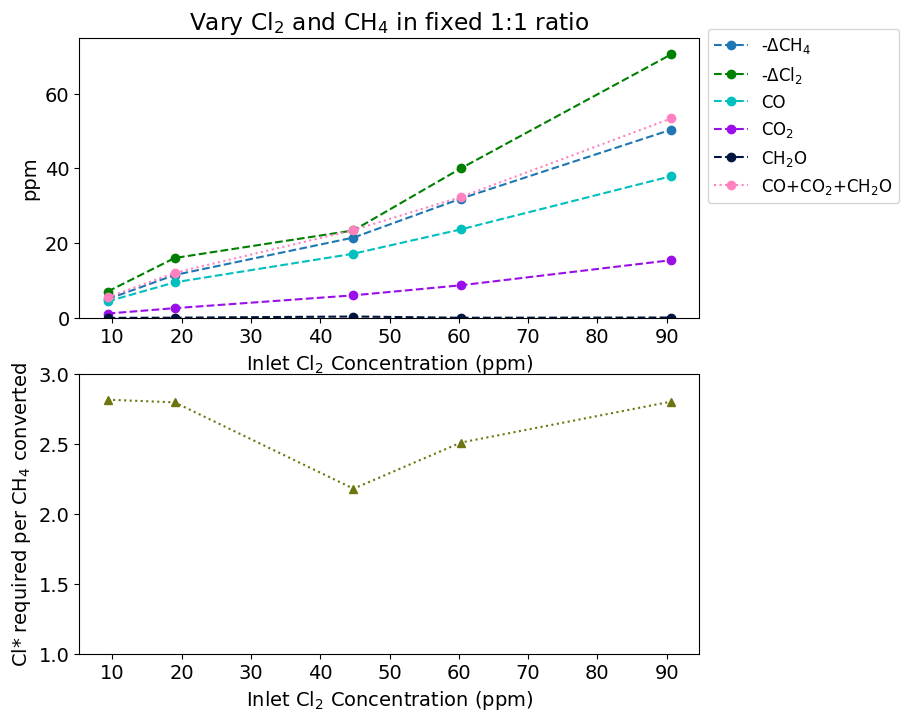

In [6]:
# Whittle it down to the experiments we want
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].str.contains("09-19-24 Sweep 1-to-1 Cl2 and CH4")]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].str.contains("09-19-24 Sweep 1-to-1 Cl2 and CH4")]
#bypass_data = all_bypass_data[all_bypass_data["experiment_name"].str.contains("09-19-24 Sweep 1-to-1 Cl2 and CH4")]
#conversion_data = all_conversion_data[all_conversion_data["experiment_name"].str.contains("09-19-24 Sweep 1-to-1 Cl2 and CH4")]
conversion_data=conversion_data.sort_values(by='Cl2 LabJack: Cl2 reading minus zero (mV) baseline',ascending=True)

conversion_data=conversion_data.sort_values(by='Selected: CH4 (ppm) baseline',ascending=True)
ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
cl2_conversions = calibrate_cl2(conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion']*1.25)
inlet_ch4 = conversion_data['Selected: CH4 (ppm) baseline']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
co2 = [float(means[means.closest_start_time==t]['FTIR: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(inlet_ch4,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(inlet_ch4,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(inlet_ch4,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(inlet_ch4,ch2o,label='CH$_2$O',color='xkcd:navy',marker='o',linestyle='--')
ax1.plot(inlet_ch4,[a+b+c for a,b,c in zip(co,co2,ch2o)],label='CO+CO$_2$+CH$_2$O',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax1.set_ylim(0,75)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(inlet_ch4,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* required per CH$_4$ converted")
ax2.set_xlabel("Inlet Cl$_2$ Concentration (ppm)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1,3)

ax1.set_title("Vary Cl$_2$ and CH$_4$ in fixed 1:1 ratio")
plt.show()

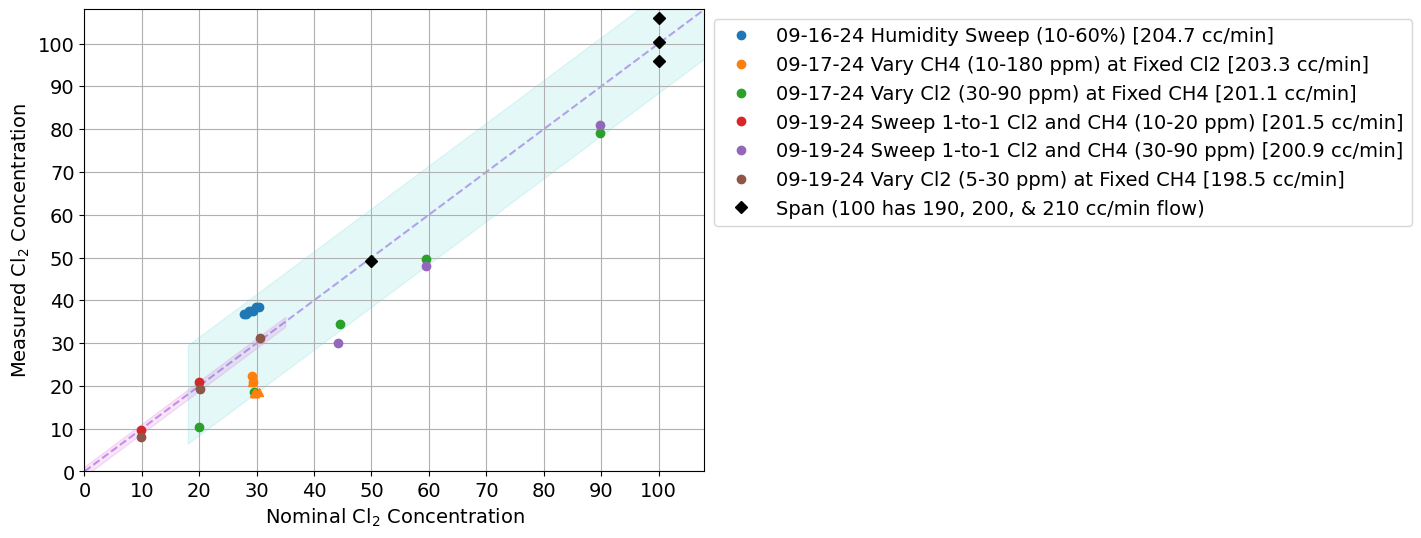

In [7]:
# Make the plot
(fig,ax) = plt.subplots(figsize=(8,6))
import numpy as np

# Directly extract the data from the conversions file
cl2_from_sensor = all_conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']
start_times = all_conversion_data['start_time']
cl2_tank_concs = [100 if (('10-20 ppm' in x) or ('5-30 ppm' in x)) else 1000 for x in all_conversion_data['experiment_name']]

# Extract the data from the bypass file
all_bypass_data['Valve Position Numeric'] = [(1 if x=='No Bubbler' else 0) for x in all_bypass_data['Bubbler Bypass Valve: Actual Position']]
means = (all_bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
cl2_mfc_flows = [float(means[means.closest_start_time==t]['Cl2 MFC: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
cl2_mfc_setpoints = [float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t in start_times] #Lookup the correct entry in the groupby
total_flows = [float(means[means.closest_start_time==t]['MFM: Actual Flow']) for t in start_times] #Lookup the correct entry in the groupby
cl2_calculated = [cl2_tank_conc*cl2_mfc_flow/total_flow for cl2_tank_conc,cl2_mfc_flow,total_flow in zip(cl2_tank_concs,cl2_mfc_flows,total_flows)]
cl2_nominal = [cl2_tank_conc*cl2_mfc_setpoint/200 for cl2_tank_conc,cl2_mfc_setpoint,total_flow in zip(cl2_tank_concs,cl2_mfc_setpoints,total_flows)]
bypass_avg = [float(means[means.closest_start_time==t]['Valve Position Numeric']) for t in start_times] #Lookup the correct entry in the groupby

# Clone conversion data
all_conversion_data["Nominal Cl2 (ppm)"] = cl2_nominal
all_conversion_data["Calculated Cl2 (ppm)"] = cl2_calculated
all_conversion_data["Valve Position Numeric"] = bypass_avg
all_conversion_data["Valve Position Numeric"] = bypass_avg
all_conversion_data["Average Flow"] = total_flows

# Do the plotting
#ax.plot(cl2_nominal,cl2_from_sensor,'go')
color = 0
for name, group in all_conversion_data.groupby(by="experiment_name"):
    subgroup = group[group['Valve Position Numeric']==1]
    if not subgroup.empty:
        flow = round(np.average(subgroup['Average Flow']),1)
        mod = " ["+str(flow)+" cc/min]"
        ax.plot(subgroup['Calculated Cl2 (ppm)'],calibrate_cl2(subgroup['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']),'o',label=name+mod,color='C'+str(color%8))
    color+=1
color = 0
for name, group in all_conversion_data.groupby(by="experiment_name"):
    subgroup = group[group['Valve Position Numeric']==0]
    if not subgroup.empty:
        ax.plot(subgroup['Calculated Cl2 (ppm)'],calibrate_cl2(subgroup['Cl2 LabJack: Cl2 reading minus zero (mV) baseline']),'^',color='C'+str(color%8))
    color+=1
m = max(cl2_from_sensor)

# Draw the spec'd region for the high range
error = 1.5+10.0
x = np.array([18,110])
y = np.array([18,110])
ax.fill_between(x, y-error, y+error,color='c',alpha=0.1)

# Draw the spec'd region for the low range
error = 0.15+1.00
x = np.array([0,35])
y = np.array([0,35])
ax.fill_between(x, y-error, y+error,color='m',alpha=0.1)

# Attempt to draw a line of best fit thru the 1000 tank results

# Attempt to draw one thru the 100 results

# Cosmetics
ax.grid(which='both')
ax.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
ax.set_yticks([0,10,20,30,40,50,60,70,80,90,100])

# Most recent data point
span = 1.23
cal = lambda x: (x-43)*30/(80.5-43)
raw_vals = [104.5,162.9,168.6,175.5]
cal_vals = [cal(x) for x in raw_vals]
#print([round(x,1) for x in cal_vals])
ax.plot([50,100,100,100],cal_vals,'kD',label='Span (100 has 190, 200, & 210 cc/min flow)')

ax.plot([0,110],[0,110],'--',color='xkcd:lavender',zorder=-10)
ax.legend(loc='upper left',bbox_to_anchor=(1,1))
ax.set_xlabel("Nominal Cl$_2$ Concentration")
ax.set_ylabel("Measured Cl$_2$ Concentration")
ax.set_xlim(0,108)
ax.set_ylim(0,108)
plt.show()